In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import local_binary_pattern
from pandas import DataFrame
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [3]:
# Define dataset paths
img_dataset = '/content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli'
dataset = '/content/drive/MyDrive/TUGAS AKHIR /HR/Groundtruths/Training Set.csv'

**PREPROCESSING**

Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00000dc7.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00000de9.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/000025d8.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00001f15.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/0000273e.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00003a57.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00001aa5.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/000025de.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/0000115b.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/0000154c.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00001a1e.png
Processing image: /content/drive/MyDrive/TU

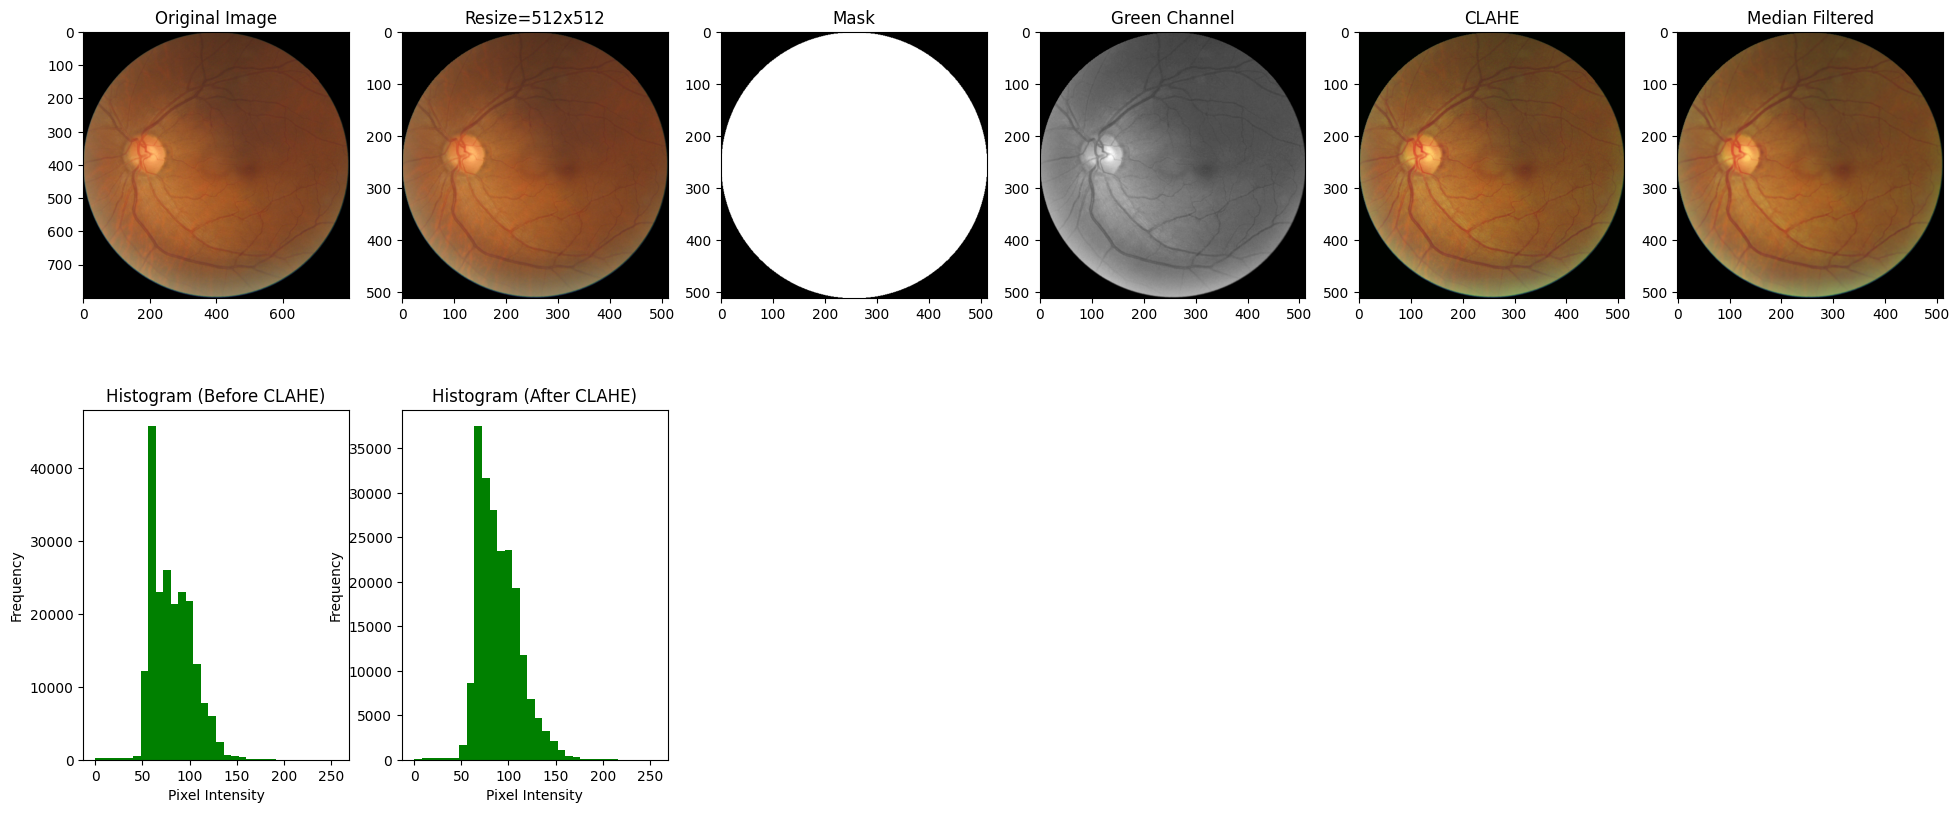

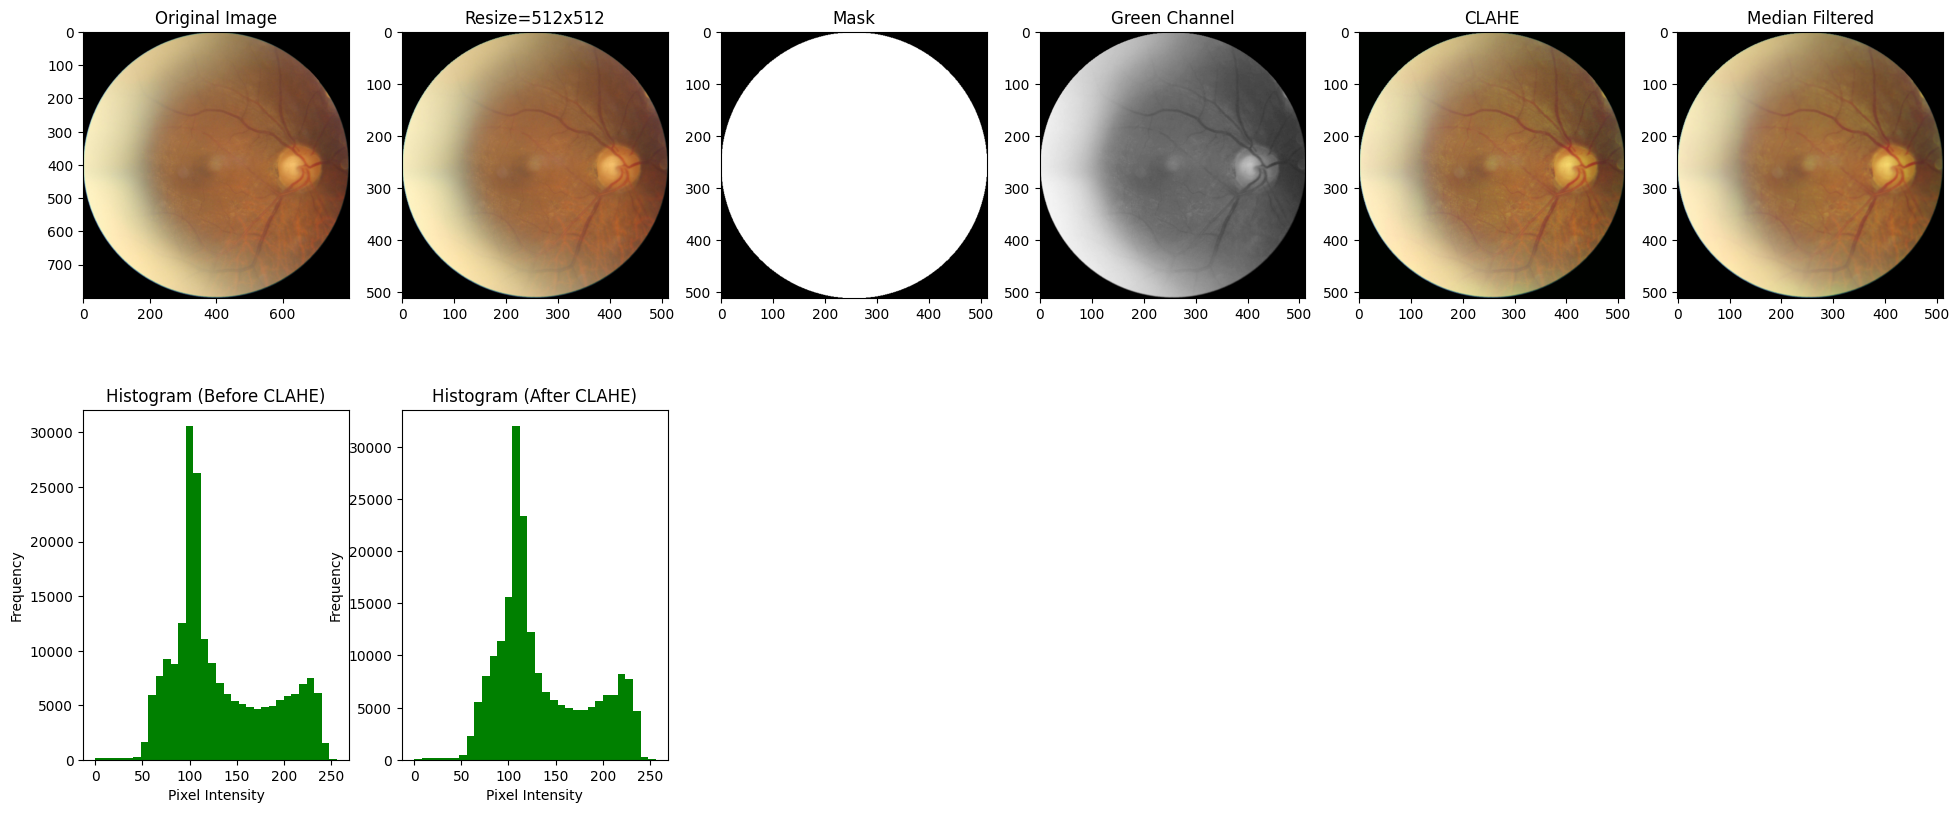

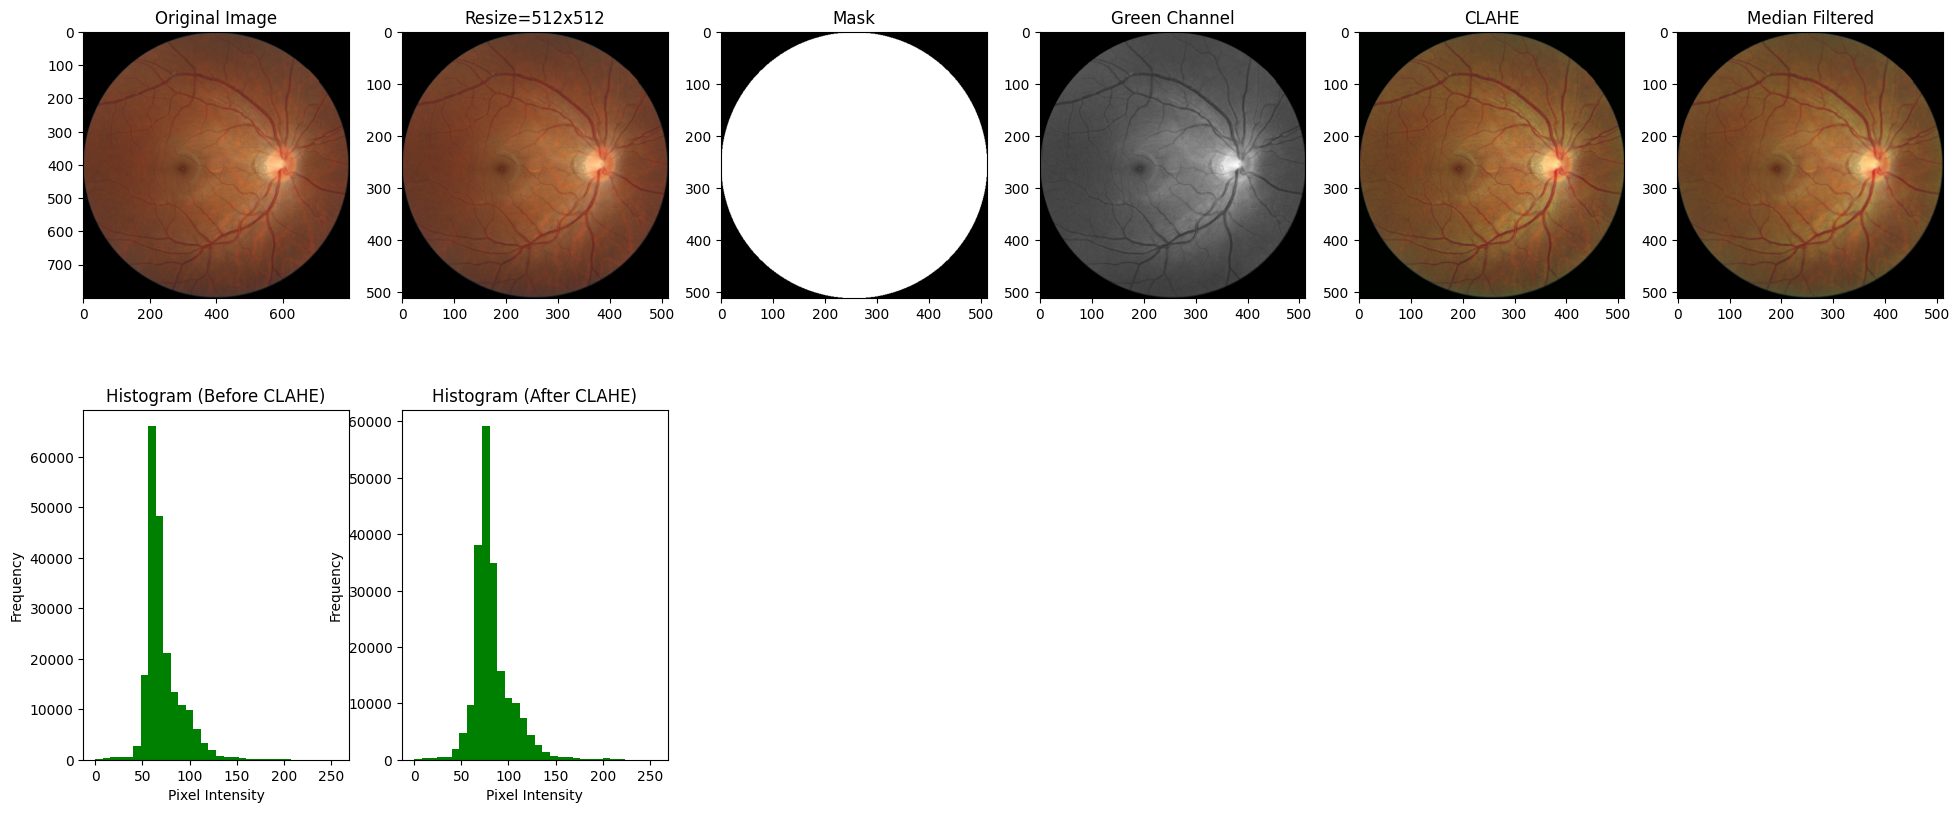

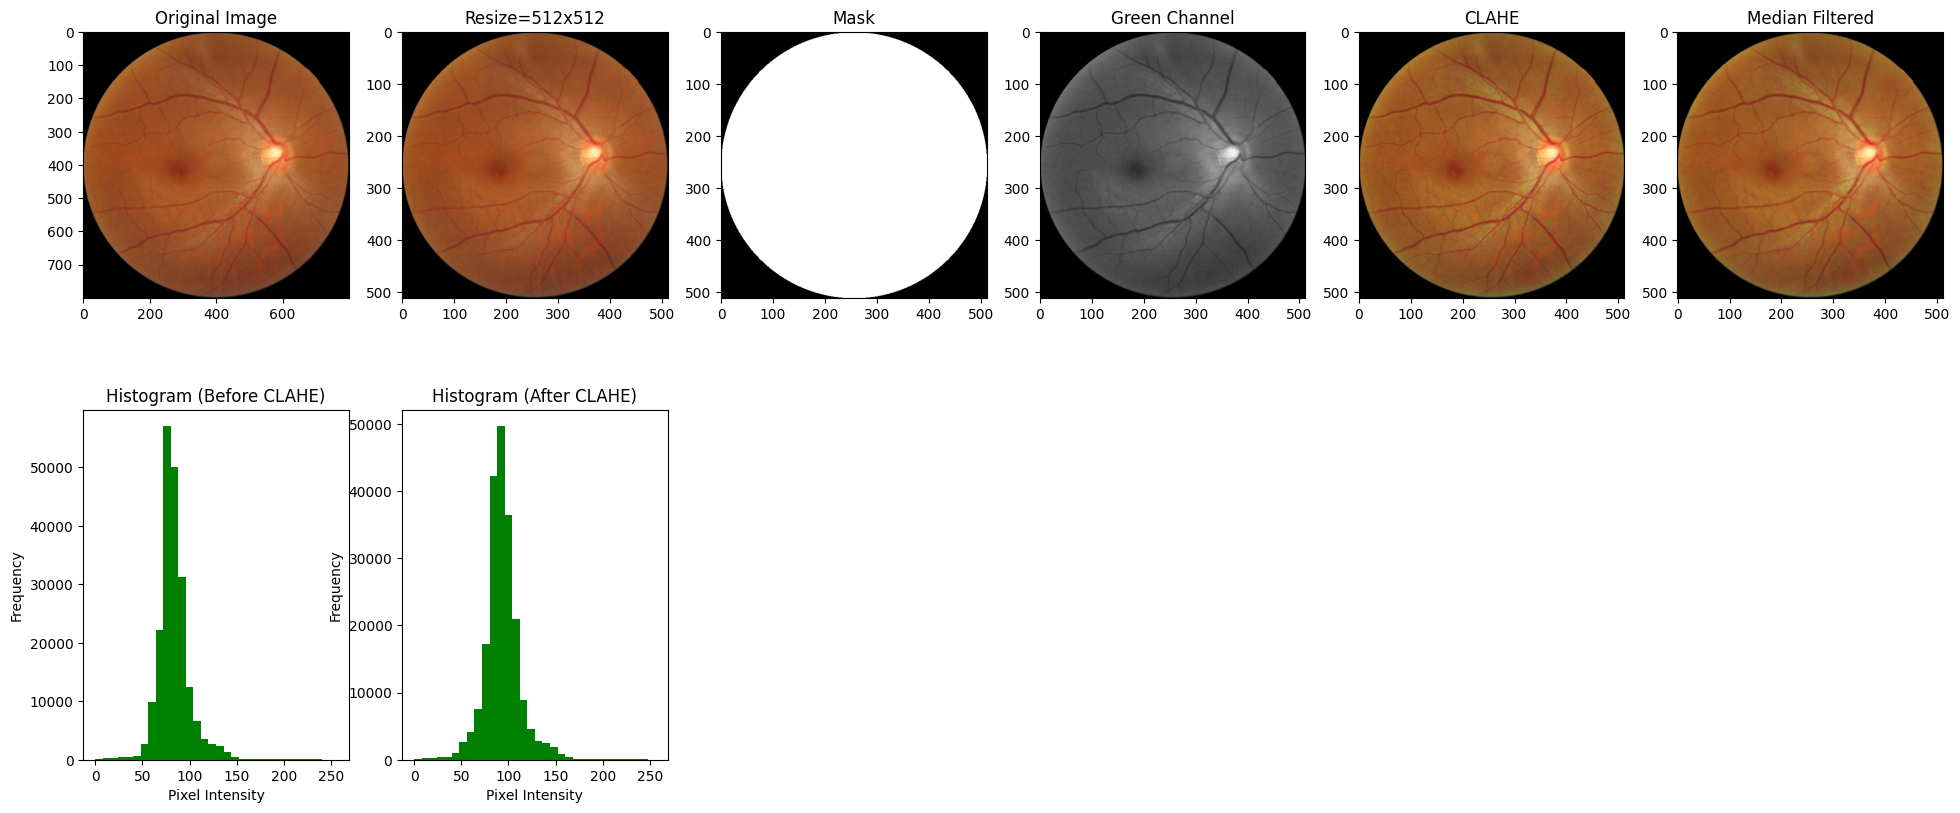

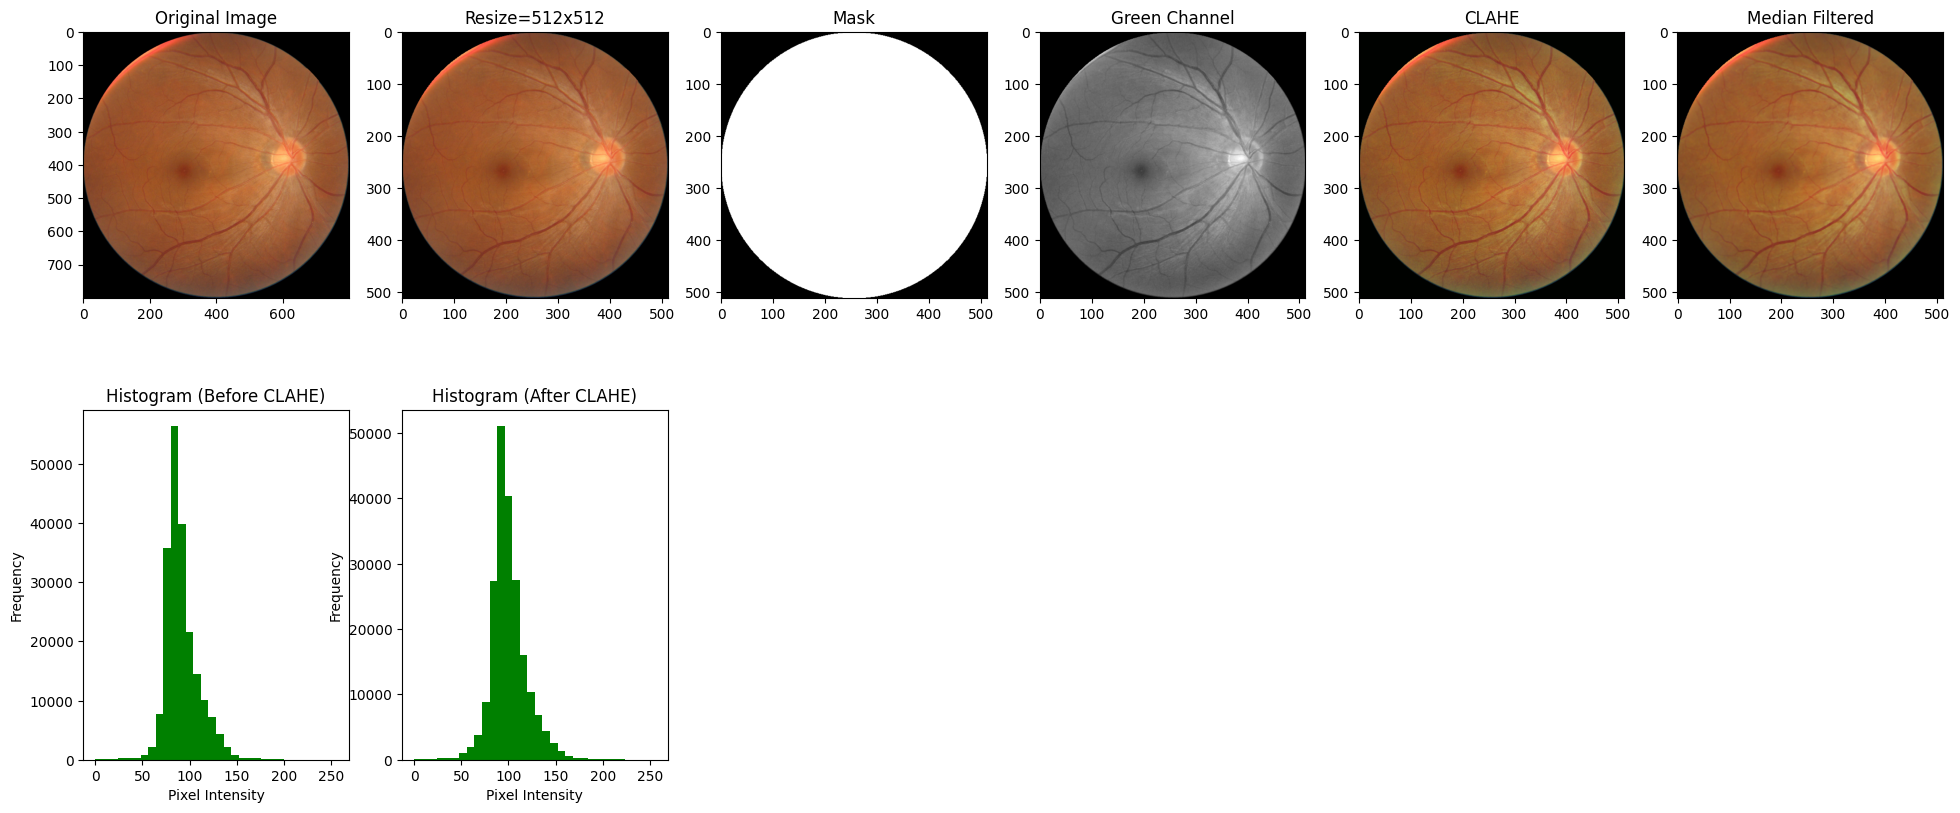

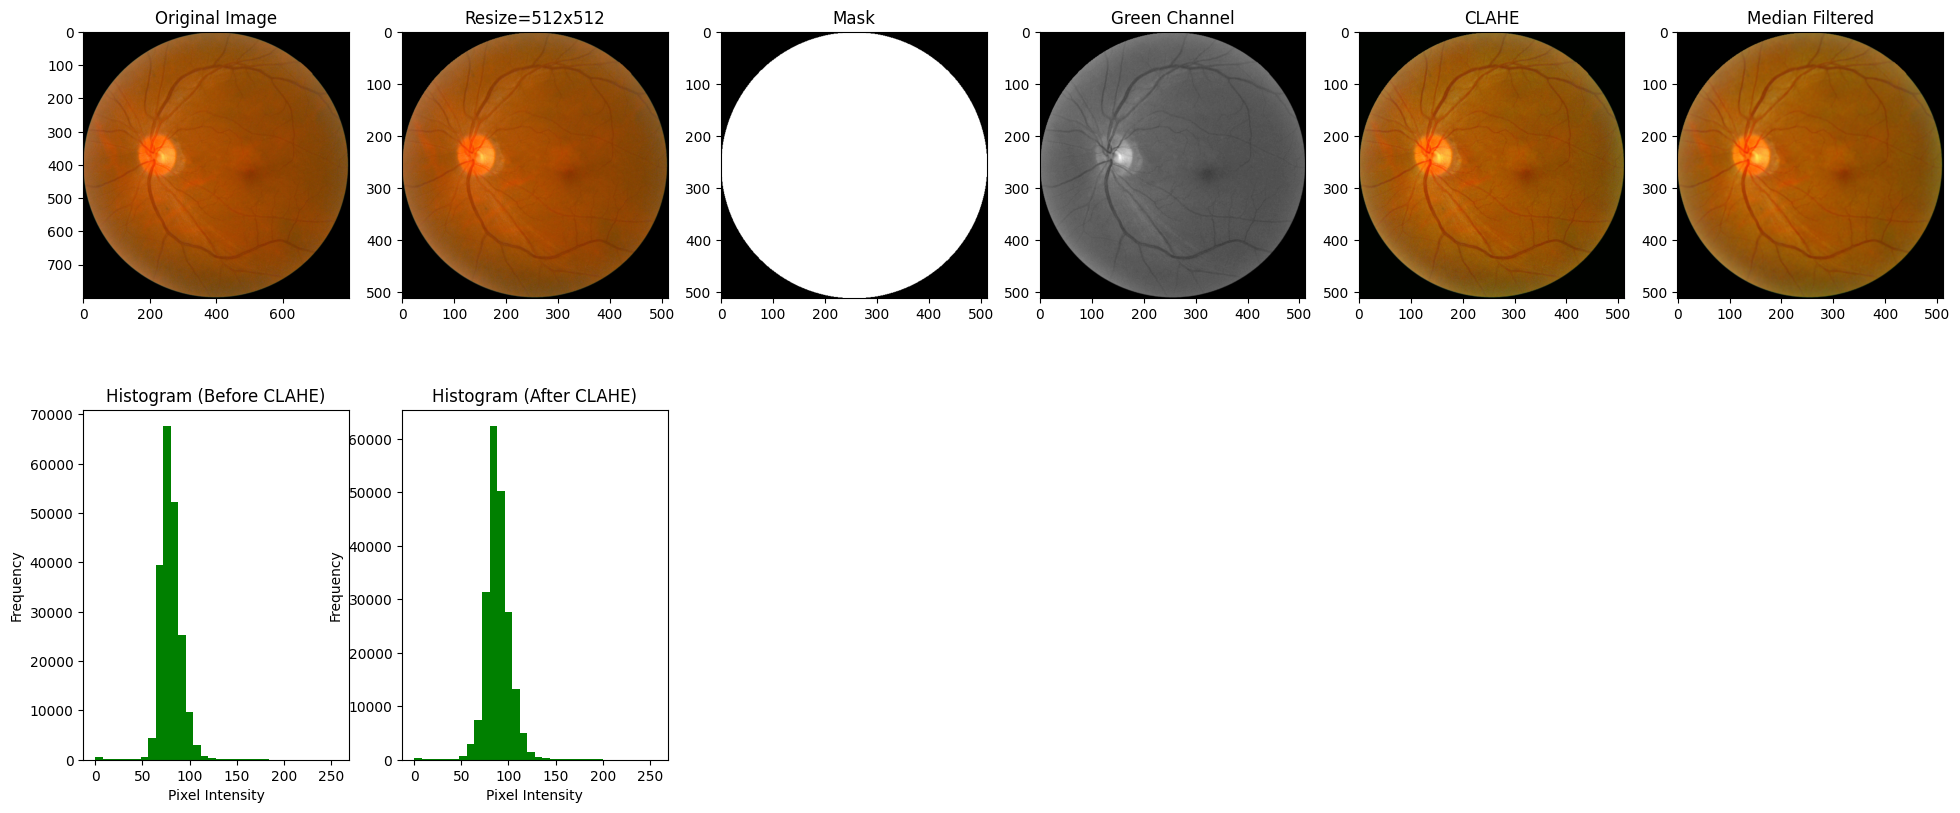

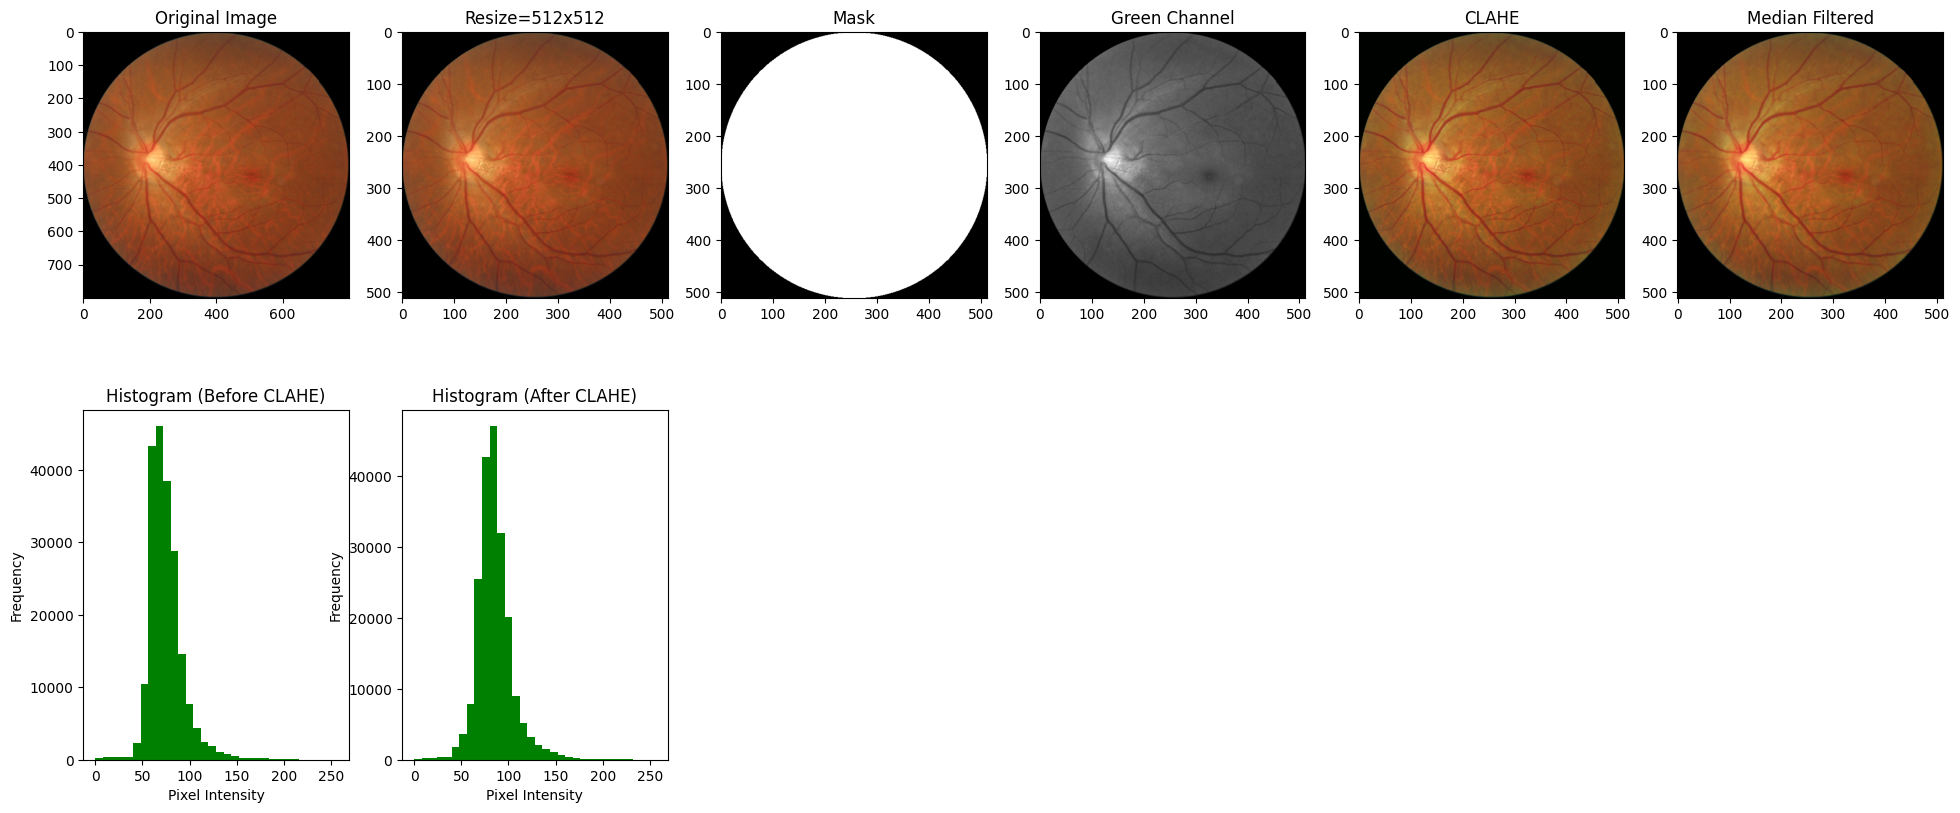

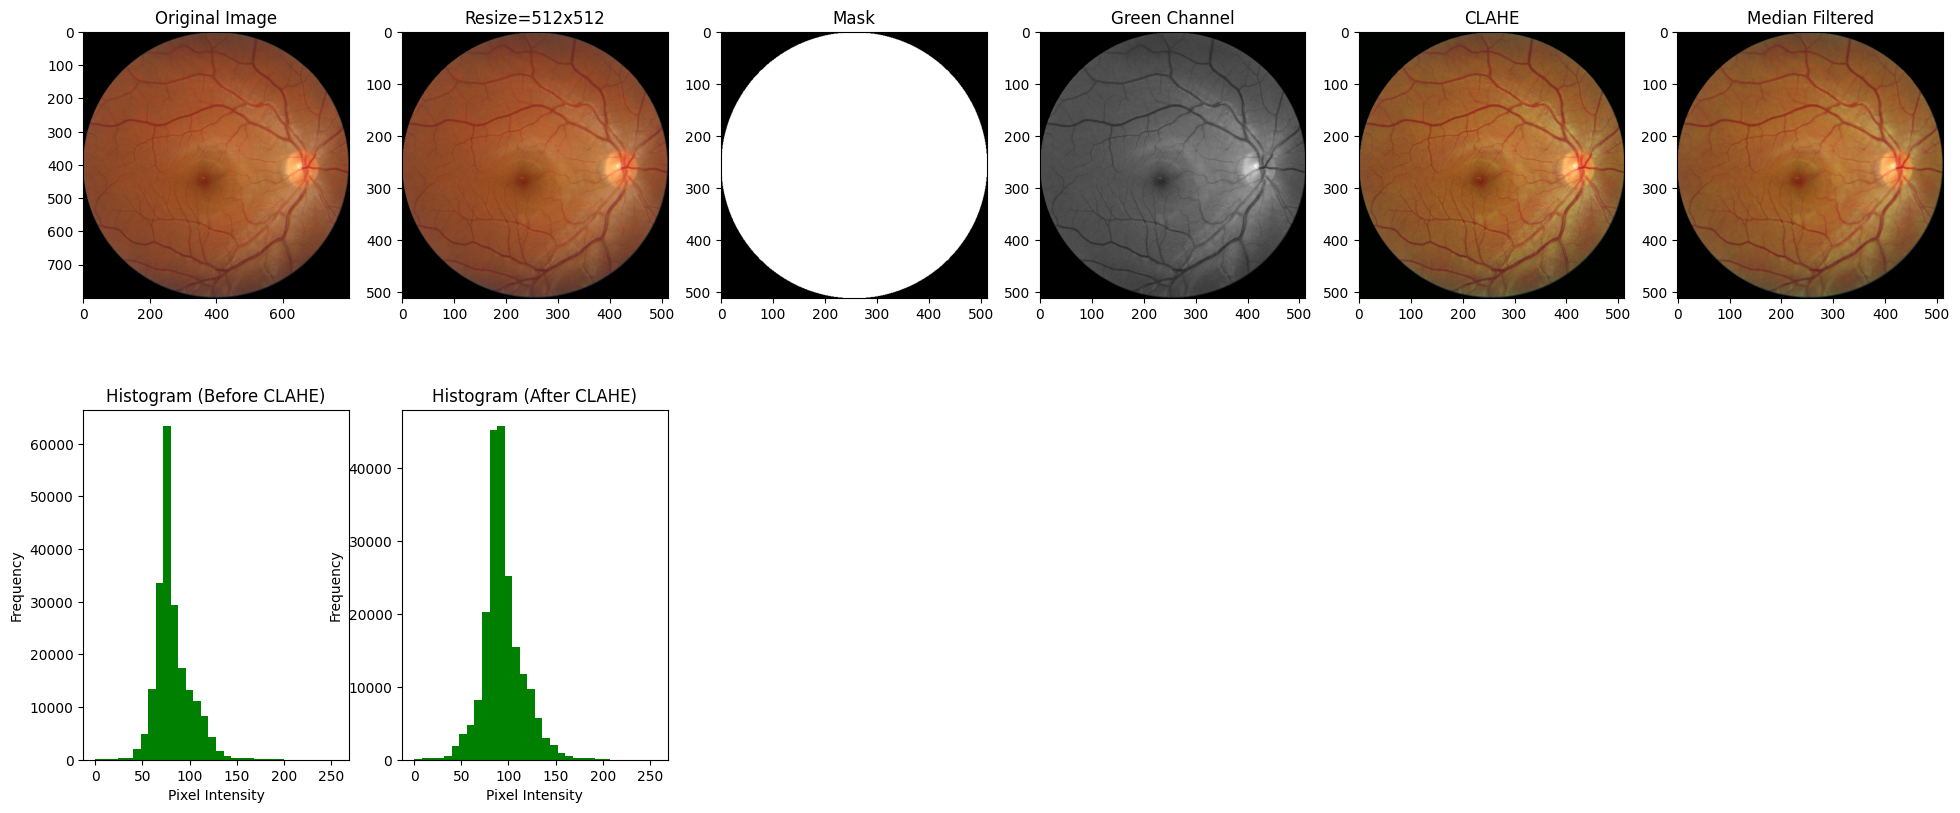

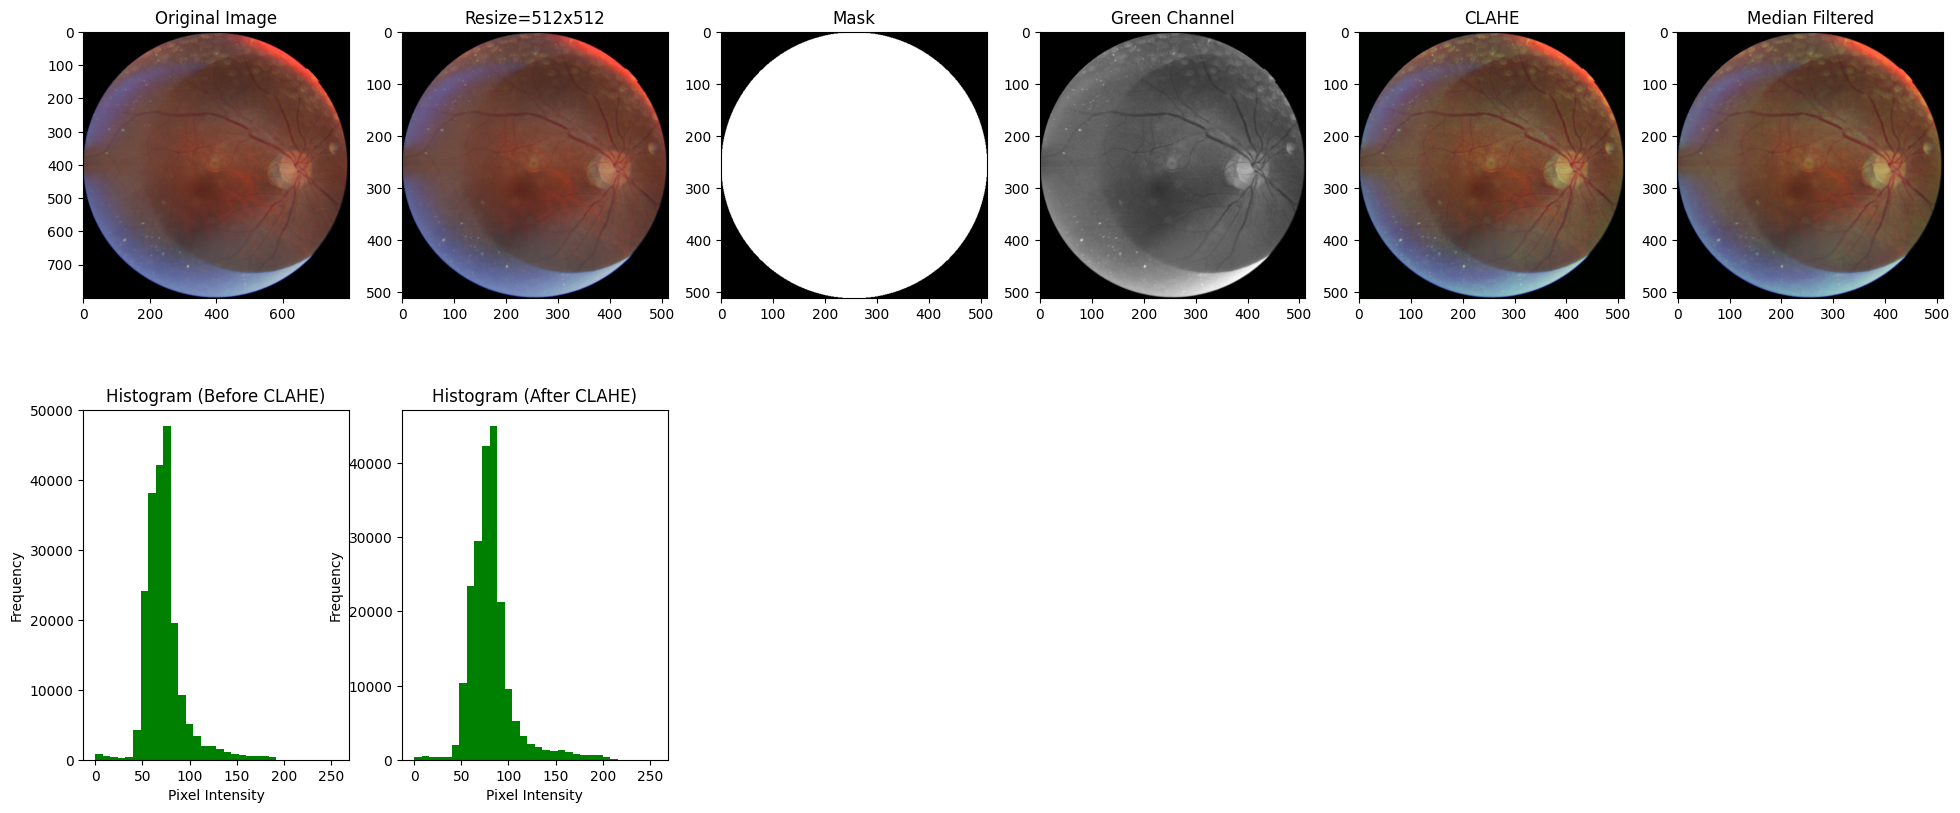

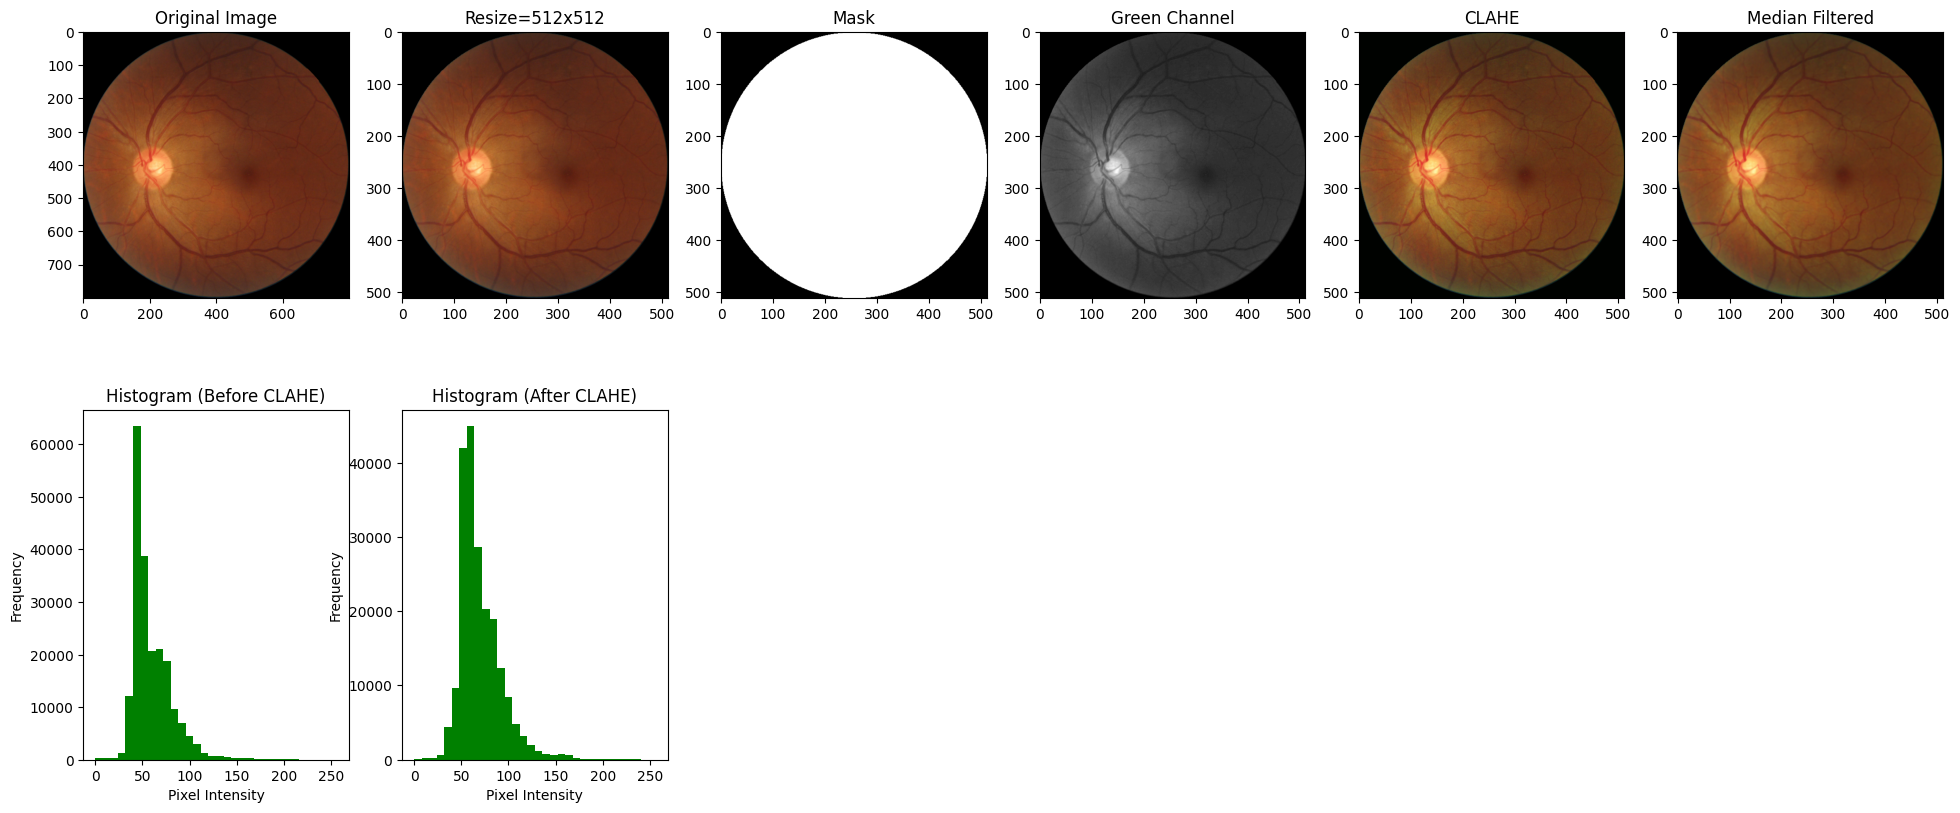

Mean MSE (CLAHE): 25.170609675989613
Mean PSNR (CLAHE): 34.1645010429615
Mean MSE (Median): 27.879957222313468
Mean PSNR (Median): 33.713825022819435


In [4]:
# Define image processing functions (unchanged)
def mean_squared_error(image1, image2):
    return np.mean((image1 - image2) ** 2)

def peak_signal_noise_ratio(image1, image2):
    mse = mean_squared_error(image1, image2)
    return 10 * np.log10(255 ** 2 / mse)

def contrast_enhance(img_clahe, clip_limit):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(15, 15))
    Red = img_clahe[..., 0]
    Green = img_clahe[..., 1]
    Blue = img_clahe[..., 2]
    Green_fix = clahe.apply(Green)
    new_img = np.stack([Red, Green_fix, Blue], axis=2)
    return new_img

def remove_black_background_circular(image):
    height, width = image.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(center[0], center[1], width - center[0], height - center[1])
    cv2.circle(mask, center, radius, 255, thickness=-1)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result, mask

def apply_mask(image, mask):
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

def process_image(image_path, clip_limit=1, target_size=(512, 512)):
    print(f"Processing image: {image_path}")
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Error reading image: {image_path}")
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    original_resize = cv2.resize(original, target_size)
    original_resize, mask = remove_black_background_circular(original_resize)
    green_channel = original_resize[..., 1]
    clahe_fix = contrast_enhance(original_resize, clip_limit)
    median = cv2.medianBlur(clahe_fix, 3)

    median_masked = apply_mask(median, mask)

    mse_clahe = mean_squared_error(original_resize, clahe_fix)
    psnr_clahe = peak_signal_noise_ratio(original_resize, clahe_fix)
    mse_median = mean_squared_error(original_resize, median)
    psnr_median = peak_signal_noise_ratio(original_resize, median)

    return original, original_resize, green_channel, clahe_fix, mask, median_masked, mse_clahe, psnr_clahe, mse_median, psnr_median

def display_images(input_images, max_images=10):
    df = DataFrame(columns=['Image', 'Resize', 'Green_Channel', 'CLAHE', 'Mask', 'Median_Masked', 'MSE_CLAHE', 'PSNR_CLAHE', 'MSE_Median', 'PSNR_Median'])
    for i, (original, original_resize, green_channel, clahe_fix, mask, median_masked, mse_clahe, psnr_clahe, mse_median, psnr_median) in enumerate(input_images, 1):
        df.loc[i] = [original, original_resize, green_channel, clahe_fix, mask, median_masked, mse_clahe, psnr_clahe, mse_median, psnr_median]

    for index, row in df.iterrows():
        if index > max_images:
            break

        plt.figure(figsize=(24, 10))

        plt.subplot(2, 6, 1)
        plt.imshow(row['Image'])
        plt.title('Original Image')

        plt.subplot(2, 6, 2)
        plt.imshow(row['Resize'])
        plt.title('Resize=512x512')

        plt.subplot(2, 6, 3)
        plt.imshow(row['Mask'], cmap='gray')
        plt.title('Mask')

        plt.subplot(2, 6, 4)
        plt.imshow(row['Green_Channel'], cmap='gray')
        plt.title('Green Channel')

        plt.subplot(2, 6, 5)
        plt.imshow(row['CLAHE'])
        plt.title('CLAHE')

        plt.subplot(2, 6, 6)
        plt.imshow(row['Median_Masked'])
        plt.title('Median Filtered')

        plt.subplot(2, 6, 7)
        green_hist = row['Green_Channel'].ravel()
        green_hist = green_hist[green_hist > 0]  # Remove zero intensity pixels
        plt.hist(green_hist, bins=32, range=[0, 256], color='green', alpha=1)
        plt.title('Histogram (Before CLAHE)')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

        plt.subplot(2, 6, 8)
        clahe_hist = row['CLAHE'][..., 1].ravel()
        clahe_hist = clahe_hist[clahe_hist > 3]  # Remove zero intensity pixels
        plt.hist(clahe_hist, bins=32, range=[0, 256], color='green', alpha=1)
        plt.title('Histogram (After CLAHE)')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()

    mean_mse_clahe = df['MSE_CLAHE'].mean()
    mean_psnr_clahe = df['PSNR_CLAHE'].mean()
    mean_mse_median = df['MSE_Median'].mean()
    mean_psnr_median = df['PSNR_Median'].mean()
    print(f"Mean MSE (CLAHE): {mean_mse_clahe}")
    print(f"Mean PSNR (CLAHE): {mean_psnr_clahe}")
    print(f"Mean MSE (Median): {mean_mse_median}")
    print(f"Mean PSNR (Median): {mean_psnr_median}")

def process_and_display_images(img_dataset):
    input_images = []
    median_images = []
    filenames = []

    for i, filename in enumerate(os.listdir(img_dataset), 1):
        image_path = os.path.join(img_dataset, filename)
        try:
            processed_image = process_image(image_path)
            input_images.append(processed_image)
            median_images.append(processed_image[5])  # Append median_masked image
            filenames.append(filename)
        except ValueError as e:
            print(e)
            continue

    display_images(input_images, max_images=10)

    return median_images, filenames  # Return the list of median images and filenames

# Proses dan tampilkan gambar
median_images, filenames = process_and_display_images(img_dataset)

**LBP**

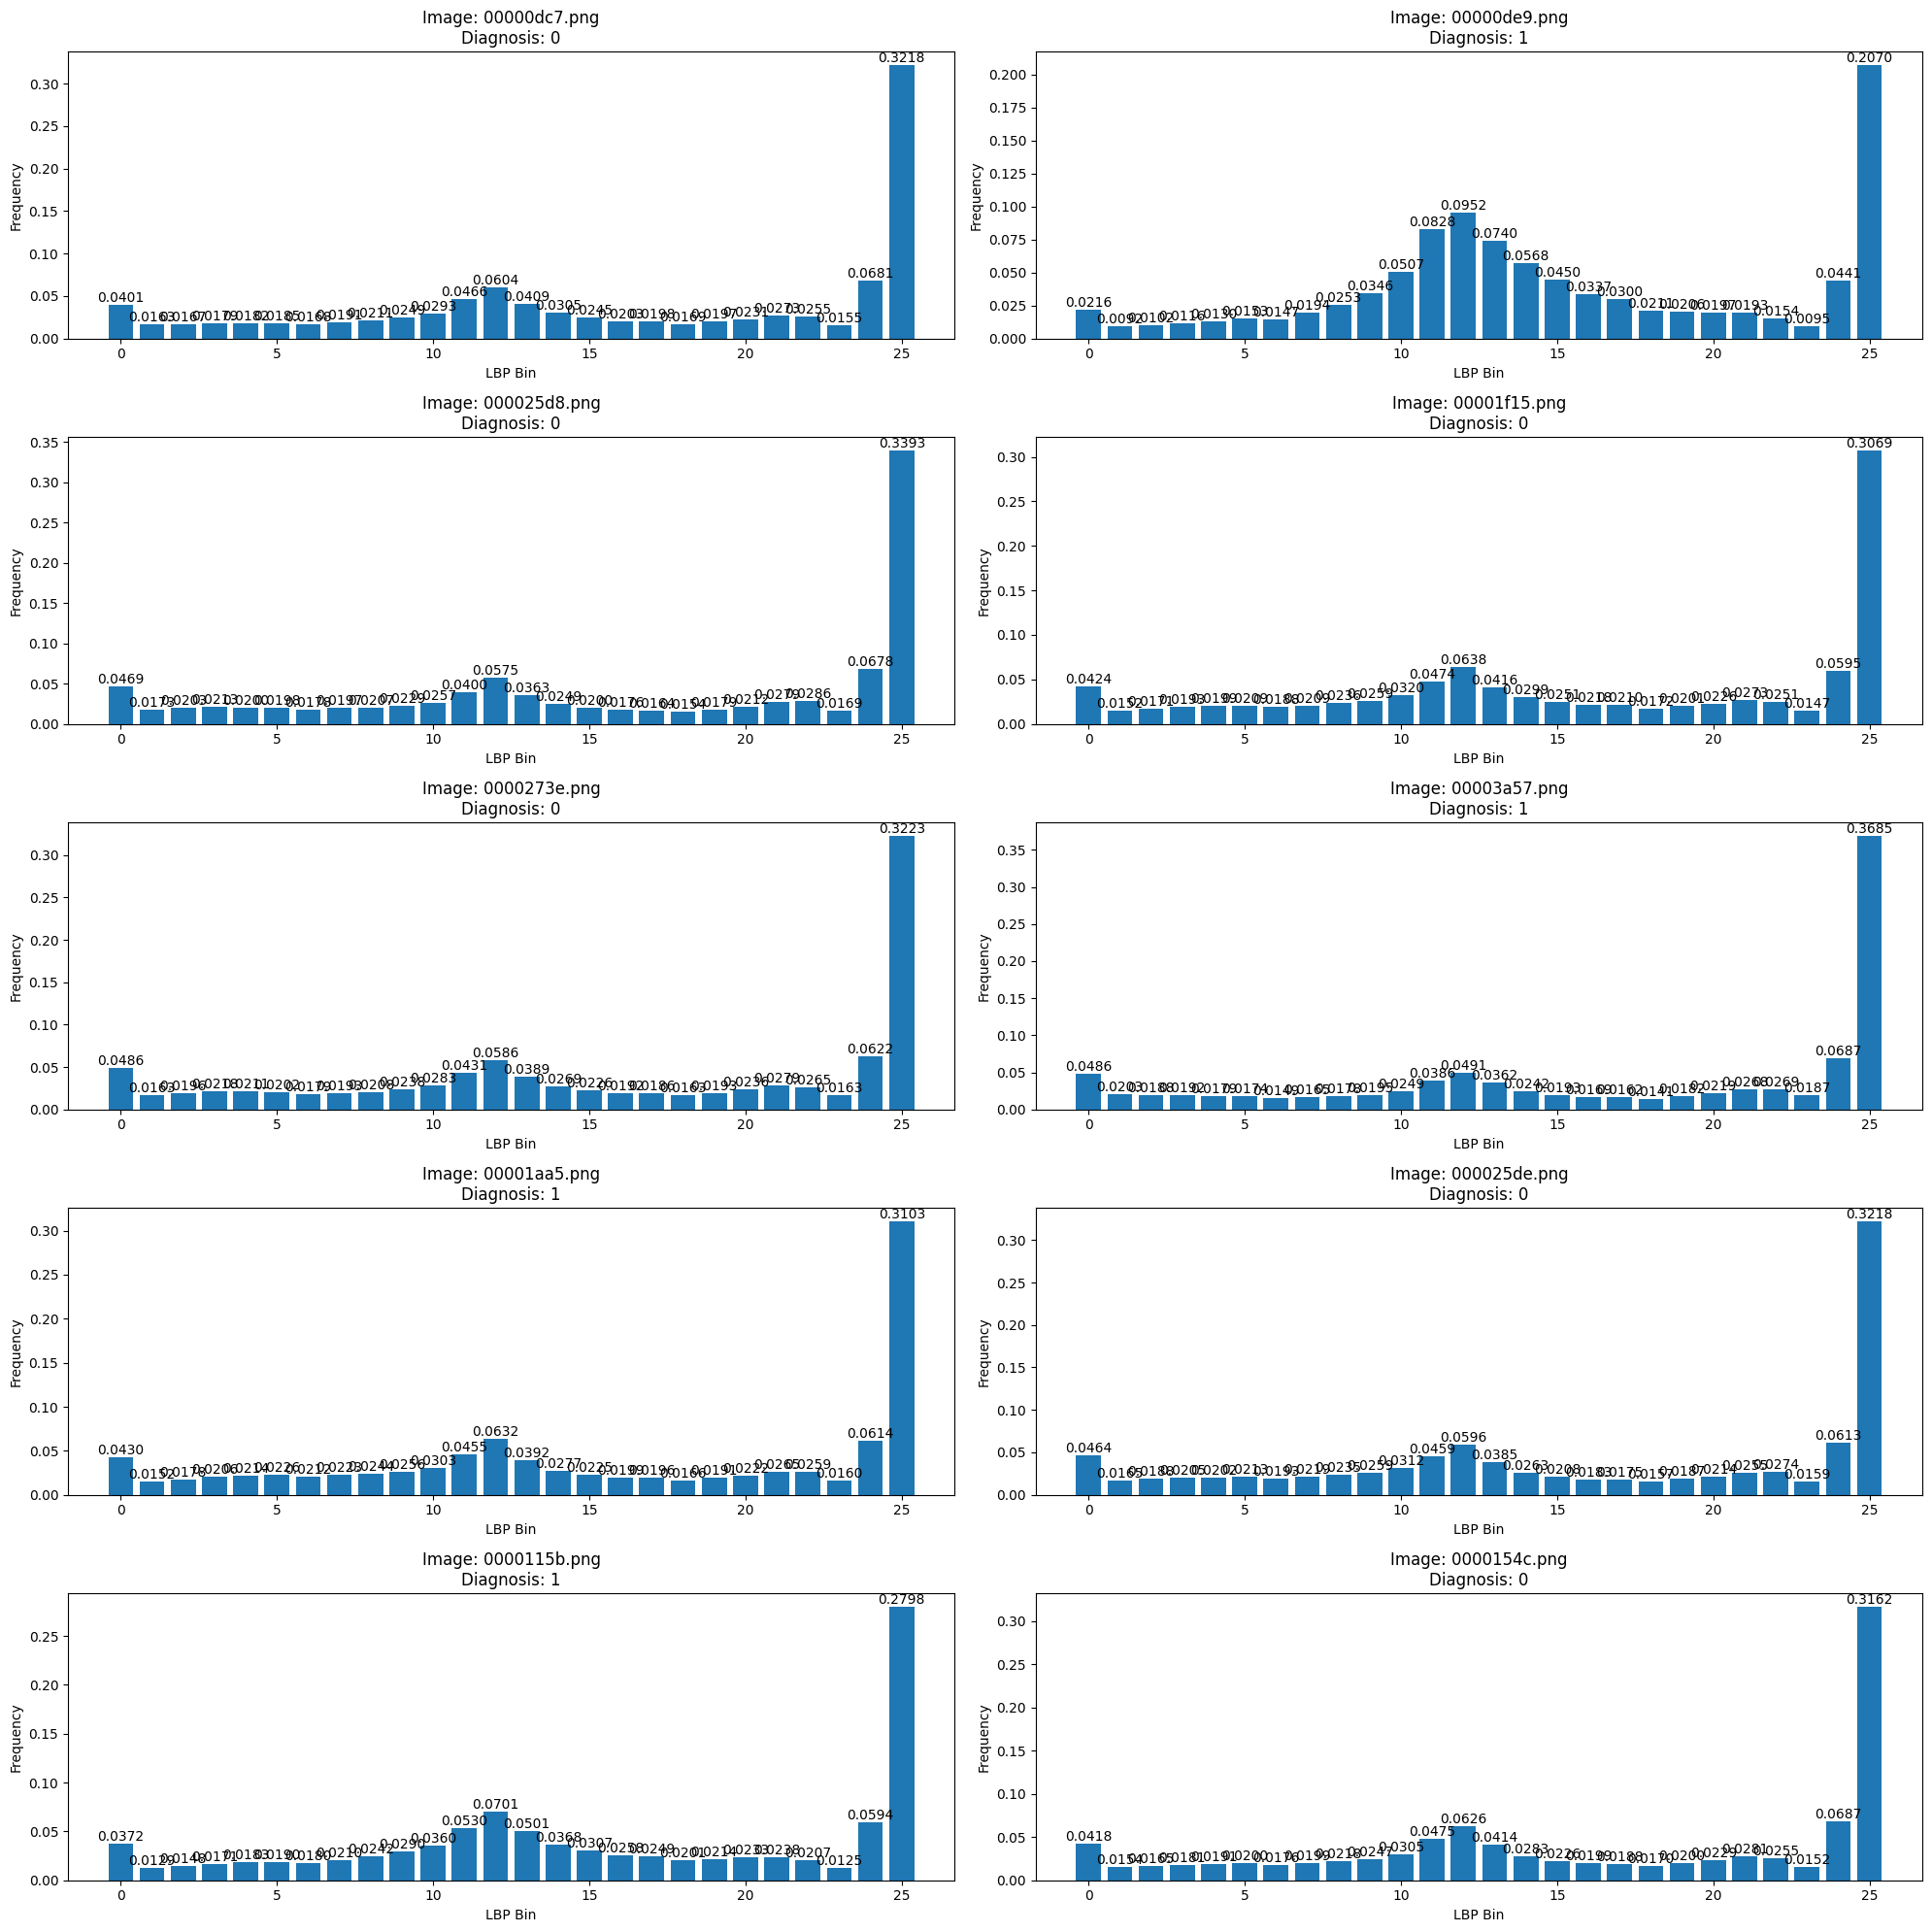

In [5]:
# Fungsi untuk menghapus latar belakang hitam pada tahap preprocessing
def remove_black_background_preprocessing(image):
    height, width = image.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(center[0], center[1], width - center[0], height - center[1])
    cv2.circle(mask, center, radius, 255, thickness=-1)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result, mask

# Fungsi untuk membuat masker pada tahap ekstraksi fitur
def remove_black_background(image, threshold=0):
    mask = image > threshold  # Membuat masker untuk piksel non-latar belakang
    return mask

# Fungsi untuk menghitung histogram LBP
def calculate_lbp_histogram(image, mask, radius=3, n_points=24):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = int(lbp.max() + 1)
    # Menghitung histogram hanya pada area non-latar belakang
    hist, _ = np.histogram(lbp[mask], bins=n_bins, range=(0, n_bins), density=True)
    return hist

# Fungsi untuk mengekstraksi fitur LBP dari beberapa gambar
def extract_lbp_features(median_images, filenames, dataset):
    lbp_features = []
    diagnosis_df = pd.read_csv(dataset)

    for image, filename in zip(median_images, filenames):
        # Tahap preprocessing: menghapus latar belakang hitam
        masked_image, _ = remove_black_background_preprocessing(image)
        gray_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)  # Konversi ke grayscale

        # Tahap ekstraksi fitur: membuat masker untuk area non-latar belakang
        mask = remove_black_background(gray_image)
        hist = calculate_lbp_histogram(gray_image, mask)

        diagnosis = diagnosis_df.loc[diagnosis_df['Image'] == filename, 'Hypertensive'].values
        diagnosis = diagnosis[0] if len(diagnosis) > 0 else None
        lbp_features.append((filename, hist, diagnosis))

    return lbp_features

# Mengekstraksi fitur LBP
lbp_features_with_filenames = extract_lbp_features(median_images, filenames, dataset)

# Fungsi untuk menampilkan histogram fitur LBP
def plot_histograms(lbp_features_with_filenames, num_images=10, num_columns=2):
    num_rows = (num_images + num_columns - 1) // num_columns  # Menghitung jumlah baris yang diperlukan

    plt.figure(figsize=(20, num_rows * 4))  # Mengatur ukuran gambar untuk menampung semua histogram
    for i in range(num_images):
        plt.subplot(num_rows, num_columns, i + 1)
        lbp_feature = lbp_features_with_filenames[i][1]
        plt.bar(range(len(lbp_feature)), lbp_feature)
        plt.title(f"Image: {lbp_features_with_filenames[i][0]}\nDiagnosis: {lbp_features_with_filenames[i][2]}")
        plt.xlabel('LBP Bin')
        plt.ylabel('Frequency')

        # Menambahkan anotasi teks ke setiap bar
        for j, value in enumerate(lbp_feature):
            plt.text(j, value, f"{value:.4f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan histogram dengan 10 gambar
plot_histograms(lbp_features_with_filenames, num_images=10)


 **SVM GridSearch**

In [ ]:
# Extract LBP features
lbp_features_with_filenames = extract_lbp_features(median_images, filenames, dataset)

# Inisialisasi list untuk menyimpan fitur LBP dan label diagnosis
lbp_features = []
diagnosis_labels = []

for filename, lbp_feature, diagnosis in lbp_features_with_filenames:
    lbp_features.append(lbp_feature)
    diagnosis_labels.append(diagnosis)

# Preprocess Data for SVM
x = np.vstack(lbp_features)
y = np.array(diagnosis_labels)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Inisialisasi model SVM
svm_model = SVC(decision_function_shape='ovr')

# Definisikan parameter grid untuk pencarian grid
parameters = {'C': [0.1, 1, 10, 100, 1000, 10000],
              'degree': [2, 3, 4, 5],
              'kernel': ['poly']}

# Define stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Buat objek GridSearchCV dengan model SVM
grid_search = GridSearchCV(svm_model, parameters, cv=stratified_kfold)

# Latih model pada data train
grid_search.fit(x_train, y_train)

# Dapatkan model terbaik
best_model = grid_search.best_estimator_

# Prediksi dengan model terbaik pada data test
y_pred = best_model.predict(x_test)

# Cetak confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Mencetak confusion matrix dengan heatmap berwarna
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Cetak classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluasi metrik untuk setiap kombinasi parameter
results = grid_search.cv_results_

# Hitung metrik evaluasi manual
def calculate_metrics(confusion_matrix):
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    TP = confusion_matrix[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    return accuracy, precision, sensitivity, specificity, F1

# Kalkulasi metrik untuk hasil terbaik
accuracy, precision, sensitivity, specificity, F1 = calculate_metrics(confusion_mat)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Akurasi: {accuracy}")
print(f"Presisi: {precision}")
print(f"Sensitivitas: {sensitivity}")
print(f"Spesifisitas: {specificity}")
print(f"F1-score: {F1}")
print(f"Cohen's Kappa: {kappa}")

# Evaluasi metrik untuk setiap kombinasi parameter
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']
params = results['params']

# Menampilkan hasil metrik untuk setiap kombinasi parameter
print("Evaluation Metrics for Each Parameter Combination:")
for mean_score, std_score, param in zip(mean_scores, std_scores, params):
    print(f"Parameter: {param}, Mean Score: {mean_score:.4f}, Std Score: {std_score:.4f}")

# Menampilkan parameter terbaik beserta mean score dan std score
best_params = grid_search.best_params_
best_mean_score = grid_search.best_score_
best_std_score = std_scores[np.argmax(mean_scores)]

print(f"\nBest Parameters: {best_params}")
print(f"Best Mean Score: {best_mean_score:.4f}")
print(f"Best Std Score: {best_std_score:.4f}")


In [ ]:
# Extract LBP features
lbp_features_with_filenames = extract_lbp_features(median_images, filenames, dataset)

# Inisialisasi list untuk menyimpan fitur LBP dan label diagnosis
lbp_features = []
diagnosis_labels = []

for filename, lbp_feature, diagnosis in lbp_features_with_filenames:
    lbp_features.append(lbp_feature)
    diagnosis_labels.append(diagnosis)

# Preprocess Data for SVM
x = np.vstack(lbp_features)
y = np.array(diagnosis_labels)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Inisialisasi model SVM
svm_model = SVC(decision_function_shape='ovr')

# Definisikan parameter grid untuk pencarian grid
parameters = {'C': [0.1, 1, 10, 100, 1000, 5000, 10000],
              'degree': [1, 2, 3, 4,5],
              'kernel': ['poly']}

# Define stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Buat objek GridSearchCV dengan model SVM
grid_search = GridSearchCV(svm_model, parameters, cv=stratified_kfold)

# Latih model pada data train
grid_search.fit(x_train, y_train)

# Dapatkan model terbaik
best_model = grid_search.best_estimator_

# Prediksi dengan model terbaik pada data test
y_pred = best_model.predict(x_test)

# Cetak confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Mencetak confusion matrix dengan heatmap berwarna
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Cetak classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluasi metrik untuk setiap kombinasi parameter
results = grid_search.cv_results_

print("Evaluation Metrics for Each Parameter Combination:")
for i in range(len(results['params'])):
    params = results['params'][i]
    best_model.set_params(**params)
    best_model.fit(x_train, y_train)
    y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    sensitivitas = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)

    confusion_mat = confusion_matrix(y_test, y_pred)
    specificity = []
    for j in range(confusion_mat.shape[0]):
        tn = confusion_mat.sum() - confusion_mat[:, j].sum() - confusion_mat[j, :].sum() + confusion_mat[j, j]
        fp = confusion_mat[:, j].sum() - confusion_mat[j, j]

        denominator = tn + fp
        if denominator != 0:
            specificity_j = tn / denominator  # specificity for class j
        else:
            specificity_j = 0  # avoid division by zero

        specificity.append(specificity_j)

    print("Parameters:", params)
    print("Akurasi pada data test:", accuracy)
    print("Presisi pada data test:", precision)
    print("Sensitivitas pada data test:", sensitivitas)
    print("F1 Score pada data test:", f1)
    print("Kappa pada data test:", kappa)
    print("Spesifisitas pada data test:", np.mean(specificity))


**Input Parameter SVM**

Confusion Matrix:
[[29  4]
 [10 29]]


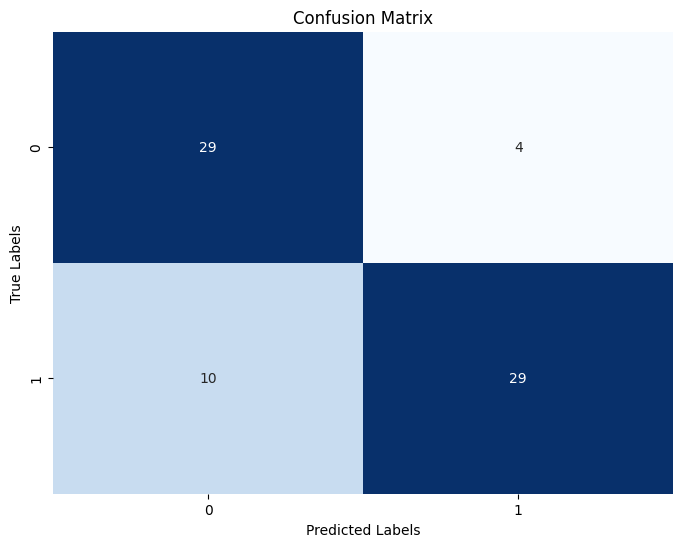

Akurasi: 0.8055555555555556
Presisi: 0.8787878787878788
Sensitivitas: 0.7435897435897436
Spesifisitas: 0.8787878787878788
Cohen's Kappa: 0.6137931034482759
F1-score: 0.8055555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81        33
           1       0.88      0.74      0.81        39

    accuracy                           0.81        72
   macro avg       0.81      0.81      0.81        72
weighted avg       0.82      0.81      0.81        72



In [6]:
# Inisialisasi list untuk menyimpan fitur LBP dan label diagnosis
lbp_features = []
diagnosis_labels = []

for filename, lbp_feature, diagnosis in lbp_features_with_filenames:
    lbp_features.append(lbp_feature)
    diagnosis_labels.append(diagnosis)

# Preprocess Data for SVM
x = np.vstack(lbp_features)
y = np.array(diagnosis_labels)

# Convert y to 2D array
y = y.reshape(-1, 1)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Inisialisasi model SVM dengan kernel polynomial
best_C = 100
best_degree = 4  # derajat polinomial
best_kernel = 'poly'
best_svm_model = SVC(C=best_C, kernel=best_kernel, degree=best_degree, decision_function_shape='ovr')

# Latih model pada data train
best_svm_model.fit(x_train, y_train.ravel())

# Prediksi dengan model pada data test
y_pred = best_svm_model.predict(x_test)

# Cetak confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Mencetak confusion matrix dengan heatmap berwarna
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Hitung metrik evaluasi manual
def calculate_metrics(confusion_matrix):
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    TP = confusion_matrix[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    #kappa = (2*(TP * TN - FN * FP))/((TP + FP) * (FP + TN) + (TP + FN) * (FN + TN))
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    return accuracy, precision, sensitivity, specificity, F1

# Kalkulasi metrik
accuracy, precision, sensitivity, specificity, F1 = calculate_metrics(confusion_mat)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Akurasi: {accuracy}")
print(f"Presisi: {precision}")
print(f"Sensitivitas: {sensitivity}")
print(f"Spesifisitas: {specificity}")
print(f"Cohen's Kappa: {kappa}")
print(f"F1-score: {F1}")

# Cetak classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


**SIMPAN MODEL**

In [7]:
import joblib
# Simpan model ke file di Google Drive
model_filename = '/content/drive/MyDrive/TUGAS AKHIR /HR/svm_modelPOLY.pkl'
joblib.dump(best_svm_model, model_filename)
print(f"Model disimpan ke file: {model_filename}")

Model disimpan ke file: /content/drive/MyDrive/TUGAS AKHIR /HR/svm_modelPOLY.pkl




---



In [ ]:
# Define image processing functions
def mean_squared_error(image1, image2):
    return np.mean((image1 - image2) ** 2)

def peak_signal_noise_ratio(image1, image2):
    mse = mean_squared_error(image1, image2)
    return 10 * np.log10(255 ** 2 / mse)

def contrast_enhance(img_clahe, clip_limit):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    Red = img_clahe[..., 0]
    Green = img_clahe[..., 1]
    Blue = img_clahe[..., 2]
    Green_fix = clahe.apply(Green)
    new_img = np.stack([Red, Green_fix, Blue], axis=2)
    return new_img

def remove_black_background_and_mask(image):
    height, width = image.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(center[0], center[1], width - center[0], height - center[1])
    cv2.circle(mask, center, radius, 255, thickness=-1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image, mask

def process_image(image_path, clip_limit=1, target_size=(512, 512)):
    print(f"Processing image: {image_path}")

    # Read the original image
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Error reading image: {image_path}")

    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Resize the original image
    original_resize = cv2.resize(original, target_size)

    # Apply masking to remove black background
    masked_image, mask = remove_black_background_and_mask(original_resize)

    green_channel = masked_image[..., 1]  # Ambil saluran hijau (green channel) dari gambar yang sudah diresize dan dimasking
    clahe_fix = contrast_enhance(masked_image, clip_limit)  # Enhance kontras menggunakan CLAHE pada gambar yang sudah diresize dan dimasking
    median = cv2.medianBlur(clahe_fix, 3)

    # Terapkan mask pada gambar hasil median filtering untuk menghilangkan latar belakang putih
    median_masked = cv2.bitwise_and(median, median, mask=mask)

    # Menghitung nilai MSE dan PSNR
    mse_clahe = mean_squared_error(original_resize, clahe_fix)
    psnr_clahe = peak_signal_noise_ratio(original_resize, clahe_fix)
    mse_median = mean_squared_error(original_resize, median)
    psnr_median = peak_signal_noise_ratio(original_resize, median)

    return original, original_resize, green_channel, clahe_fix, median, mse_clahe, psnr_clahe, mse_median, psnr_median, mask, median_masked


def display_images(input_images, max_images=2):
    df = DataFrame(columns=['Original', 'Resize', 'Green_Channel', 'CLAHE', 'Median', 'MSE_CLAHE', 'PSNR_CLAHE', 'MSE_Median', 'PSNR_Median', 'Mask', 'Median_Masked'])
    for i, (original, original_resize, green_channel, clahe_fix, median, mse_clahe, psnr_clahe, mse_median, psnr_median, mask, median_masked) in enumerate(input_images, 1):
        df.loc[i] = [original, original_resize, green_channel, clahe_fix, median, mse_clahe, psnr_clahe, mse_median, psnr_median, mask, median_masked]

    for index, row in df.iterrows():
        if index > max_images:
            break

        plt.figure(figsize=(24, 10))

        plt.subplot(2, 7, 1)
        plt.imshow(row['Original'])
        plt.title('Original Image')

        plt.subplot(2, 7, 2)
        plt.imshow(row['Resize'])
        plt.title('Resize (512x512)')

        plt.subplot(2, 7, 3)
        plt.imshow(row['Green_Channel'], cmap='gray')
        plt.title('Green Channel')

        plt.subplot(2, 7, 4)
        plt.imshow(row['CLAHE'])
        plt.title('CLAHE Enhanced')

        plt.subplot(2, 7, 5)
        plt.imshow(row['Median'])
        plt.title('Median Filtered')

        plt.subplot(2, 7, 6)
        plt.imshow(row['Mask'], cmap='gray')
        plt.title('Mask')

        plt.subplot(2, 7, 7)
        plt.imshow(row['Median_Masked'])
        plt.title('Median Masked')

        plt.subplot(2, 7, 8)
        green_hist = row['Green_Channel'].ravel()
        green_hist = green_hist[green_hist > 0]  # Remove zero intensity pixels
        plt.hist(green_hist, bins=32, range=[0, 256], color='green', alpha=1)
        plt.title('Histogram (Green Channel)')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

        plt.subplot(2, 7, 9)
        clahe_hist = row['CLAHE'][..., 1].ravel()
        clahe_hist = clahe_hist[clahe_hist > 3]  # Remove zero intensity pixels
        plt.hist(clahe_hist, bins=32, range=[0, 256], color='green', alpha=1)
        plt.title('Histogram (CLAHE Green Channel)')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()

    # Menampilkan nilai rata-rata MSE dan PSNR
    mean_mse_clahe = df['MSE_CLAHE'].mean()
    mean_psnr_clahe = df['PSNR_CLAHE'].mean()
    mean_mse_median = df['MSE_Median'].mean()
    mean_psnr_median = df['PSNR_Median'].mean()
    print(f"Mean MSE (CLAHE): {mean_mse_clahe}")
    print(f"Mean PSNR (CLAHE): {mean_psnr_clahe}")
    print(f"Mean MSE (Median): {mean_mse_median}")
    print(f"Mean PSNR (Median): {mean_psnr_median}")

def process_and_display_images(img_dataset):
    input_images = []
    median_images = []
    filenames = []

    for i, filename in enumerate(os.listdir(img_dataset), 1):
        image_path = os.path.join(img_dataset, filename)
        try:
            processed_image = process_image(image_path)
            input_images.append(processed_image)
            median_images.append(processed_image[10])  # Ambil median_masked yang sudah dalam RGB
            filenames.append(filename)
        except ValueError as e:
            print(e)
            continue

    display_images(input_images, max_images=2)  # Tampilkan hanya 10 gambar pertama untuk visualisasi
    return median_images, filenames

# Proses dan tampilkan gambar
median_images, filenames = process_and_display_images(img_dataset)

Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00000dc7.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00000de9.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/000025d8.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00001f15.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/0000273e.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00003a57.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00001aa5.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/000025de.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/0000115b.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/0000154c.png
Processing image: /content/drive/MyDrive/TUGAS AKHIR /HR/Images/Data_Asli/00001a1e.png
Processing image: /content/drive/MyDrive/TU